In [1]:
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

### Pyramidal Cell

In [2]:
eqns = ''' 

# CONSTANTS 

## DON'T vary between compartments
E_na = 55*mV : volt
E_leak = -70*mV : volt
ca_rest = 50*nmole/liter : mole/meter**3
k_rest = 3.82*mmole/liter : mole/meter**3
phi_k = 2 : 1
F = 96485.33289 * coulomb/mole : coulomb/mole  # Faraday's constant

## DO vary between compartments
phi_ca : 1
ca_out : mole/meter**3
k_in : mole/meter**3
g_na : siemens/meter**2
g_nap : siemens/meter**2
g_hva : siemens/meter**2
g_dr : siemens/meter**2
g_ks : siemens/meter**2
g_c : siemens/meter**2
g_leak : siemens/meter**2
k_nap_alpha_m : 1 
k_nap_beta_m : 1
k_nap_alpha_h : 1
k_nap_beta_h : 1
tau_ca : second
tau_k : second


# TOTAL CURRENT
Im = I_leak + I_na + I_nap + I_dr + I_c + I_ks + I_hva : amp/meter**2


# INJECTED
I : amp (point current)


# LEAK
I_leak = g_leak * (E_leak - v) : amp/meter**2


# SODIUM
I_na = g_na * (E_na - v) * m_na**3 * h_na : amp/meter**2
dm_na/dt = (m_na_inf - m_na) / tau_m_na : 1
m_na_inf = alpha_m_na / (alpha_m_na + beta_m_na) : 1
tau_m_na = ms / (alpha_m_na + beta_m_na) : second
alpha_m_na = (-0.2816/mV)*(v + 28*mV) / (-1 + exp(-(v+28*mV)/(9.3*mV))) : 1
beta_m_na = (0.2464/mV)*(v + 1*mV) / (-1 + exp((v+1*mV)/(6*mV))) : 1
dh_na/dt = (h_na_inf - h_na) / tau_h_na : 1
h_na_inf = alpha_h_na / (alpha_h_na + beta_h_na) : 1
tau_h_na = ms / (alpha_h_na + beta_h_na) : second
alpha_h_na = 0.098*exp(-(v+43.1*mV)/(20*mV)) : 1  # a/exp((v+b)/c) in NEURON code, a*exp(-(v+b)/c) in paper
beta_h_na = 1.4 / (1 + exp(-(v+13.1*mV)/(10*mV))) : 1

I_nap = g_nap * (E_na - v) * m_nap * h_nap: amp/meter**2
dm_nap/dt = (m_nap_inf - m_nap) / tau_m_nap : 1
m_nap_inf = alpha_m_nap / (alpha_m_nap + beta_m_nap) : 1
tau_m_nap = ms / (alpha_m_nap + beta_m_nap) : second
alpha_m_nap = (-0.2816/mV)*(v + k_nap_alpha_m*mV) / (-1 + exp(-(v + k_nap_alpha_m*mV)/(9.3*mV))) : 1
beta_m_nap = (0.2464/mV)*(v - k_nap_beta_m*mV) / (-1 + exp((v - k_nap_beta_m*mV)/(6*mV))) : 1
dh_nap/dt = (h_nap_inf - h_nap) / tau_h_nap : 1
h_nap_inf = alpha_h_nap / (alpha_h_nap + beta_h_nap) : 1
tau_h_nap = ms / (alpha_h_nap + beta_h_nap) : second
alpha_h_nap = k_nap_alpha_h * exp(-(v+42.8477*mV)/(4.0248*mV)) : 1
beta_h_nap = k_nap_beta_h / (1 + exp(-(v-413.9284*mV)/(148.2589*mV))) : 1


# CALCIUM
E_ca = 12.5*mV * log(ca_out / clip(ca_in, 1e-12*molar, 1e10*molar))  : volt
# dca_in/dt = -phi_ca * (I_hva * area / (F*vol_shell_ca)) + (ca_rest - ca_in)/tau_ca : mole/meter**3  # from paper
dca_in/dt = phi_ca * I_hva / (F*r_shell_ca) + (ca_rest - ca_in)/(tau_ca) : mole/meter**3  # from NEURON

I_hva = g_hva * (E_ca - v) * u_hva**2 * v_hva  : amp/meter**2
du_hva/dt = (u_hva_inf - u_hva) / tau_u_hva : 1
u_hva_inf = 1 / (1 + exp(-(v + 24.6*mV)/(11.3*mV))) : 1
# tau_u_hva = 1.25*ms / cosh(-(0.031/mV)*((v+37.1*mV))) : second  # sech = 1/cosh
tau_u_hva = 1.25*ms * 2 / (exp(-(0.031/mV)*((v+37.1*mV))) + exp((0.031/mV)*((v+37.1*mV)))) : second  # from code
dv_hva/dt = (v_hva_inf - v_hva) / tau_v_hva : 1
v_hva_inf = 1 / (1 + exp((v + 12.6*mV)/(18.9*mV))) : 1
tau_v_hva = 420.0*ms : second # blazeit


# POTASSIUM
E_k = 25.0*mV * log(clip(k_out, 1e-12*molar, 1e10*molar) / k_in) : volt
# dk_out/dt = -phi_k * ((I_dr + I_ks + I_c)*area / (F*vol_shell_k)) + (k_rest - k_out)/tau_k : mole/meter**3  # paper surf_area
dk_out/dt = -phi_k * (I_dr + I_ks + I_c) / (F*r_shell_k) + (k_rest - k_out)/tau_k : mole/meter**3  # NEURO

I_dr = g_dr * (E_k - v) * n_dr**4 : amp/meter**2
dn_dr/dt = (n_dr_inf - n_dr) / tau_n_dr : 1
n_dr_inf = alpha_n_dr / (alpha_n_dr + beta_n_dr) : 1
tau_n_dr = ms / (alpha_n_dr + beta_n_dr) : second
alpha_n_dr = (-0.018/mV)*(v - 13*mV) / (-1 + exp(-(v - 13*mV)/(25*mV))) : 1
beta_n_dr = (0.0054/mV)*(v - 23*mV) / (-1 + exp((v - 23*mV)/(12*mV))) : 1

I_ks =  g_ks * (E_k - v) * a_ks * b_ks : amp/meter**2
da_ks/dt = (a_ks_inf - a_ks) / tau_a_ks : 1
a_ks_inf = 1 / (1 + exp(-(v + 34*mV)/(6.5*mV))) : 1
tau_a_ks = 6.0*ms : second
db_ks/dt = (b_ks_inf - b_ks) / tau_b_ks : 1
b_ks_inf = 1 / (1 + exp((v + 65*mV)/(6.6*mV))) : 1
tau_b_ks = ms * (200 + 3200 / (1 + exp(-(v + 63.6*mV)/(4*mV)))) : second

I_c = g_c * (E_k - v) * c_c**2 : amp/meter**2
dc_c/dt = (c_c_inf - c_c) / tau_c_c : 1
c_c_inf = alpha_c_c / (alpha_c_c + beta_c_c) : 1
tau_c_c = ms * clip(1 / (alpha_c_c + beta_c_c), 1.1, 1e10) : second
alpha_c_c = (1/mV)*(-0.00642*v_s - 0.1152*mV) / (-1 + exp(-(v_s + 18*mV)/(12*mV))) : 1
beta_c_c = 1.7 * exp(-(v_s + 152*mV)/(30*mV)) : 1
v_s = v + 40*mV*log10(clip(ca_in, 1e-12*molar, 1e10*molar)/(umole/liter)) : volt  # ca_in*1000?

'''

In [14]:
# Morphology
Cm_soma = 1.2*ufarad/cm**2
Ri = 150*ohm*cm
r_basal =  8.0*um
r_soma = 11.5*um
r_prox = 1.3*um
r_dist = 1.3*um
l_basal = 150*um
l_prox = 400*um
l_dist = 400*um
r_shell_ca = 0.2*nmeter
r_shell_k = 70*nmeter
n_sections = 10
numerical_method = 'exponential_euler'

soma = Soma(diameter=2*r_soma)
soma.basal = Cylinder(length=l_basal, diameter=2*r_basal, n=n_sections)
soma.prox = Cylinder(length=l_prox, diameter=2*r_prox, n=n_sections)
soma.prox.dist = Cylinder(length=l_dist, diameter=2*r_dist, n=n_sections)

# Create Neuron
PC = SpatialNeuron(morphology=soma, model=eqns, method=numerical_method,
    refractory="m_na > 0.4", threshold="m_na > 0.5", Cm=Cm_soma, Ri=Ri)

# State Variable Initial Conditions

defaultclock.dt = 0.025*ms
PC.v = -65.6*mV
PC.I = 0*amp

# these values represent steady-state values of gating variables (x_inf @ v_rest=-65.6mV)
PC.m_na = 0.01173920273286167
PC.h_na = 0.9763619837454727
PC.m_nap = 0.0023884542349093783
PC.h_nap = 0.913313085277981
PC.u_hva = 0.025873533157664334
PC.v_hva = 0.942904192898275
PC.n_dr = 0.1174976486689116
PC.a_ks = 0.007679117244093778
PC.b_ks = 0.5227124847686465
PC.c_c = 0.0003160682800247177
PC.ca_in = 49.9*nmole/liter  # setting equal to equil values can cause nans, even with clip
PC.k_out = 3.819*mmole/liter  # setting equal to equil values can cause nans, even with clip

# Soma (also sets to other compartments unless otherwise specified)
PC.Cm = 1.2*ufarad/cm**2
PC.g_leak = 0.0333*msiemens/cm**2
PC.g_na = 86.0*msiemens/cm**2
PC.g_nap = 2.2*msiemens/cm**2
PC.g_hva = 0.34*msiemens/cm**2  # 0%DA=0.34, 100%DA=0.272
PC.g_dr = 33.8*msiemens/cm**2
PC.g_ks = 0.14*msiemens/cm**2  # 0%DA=0.14, 100%DA=0.07
PC.g_c = 2.2*msiemens/cm**2
PC.k_nap_alpha_m = 12  # 0%DA=12, 100%DA=17 OR 14?
PC.k_nap_beta_m = 15  # 0%DA=15, 100%DA=10
PC.k_nap_alpha_h = 2.8e-5  # 0%DA=2.8e-5, 100%DA=2.0e-5
PC.k_nap_beta_h = 0.02  # 0%DA=0.02, 100%DA=0.014286
PC.tau_ca = 250.0*ms  # NEURON code overwrites all to 70ms?
PC.tau_k = 7.0*ms
PC.phi_ca = 386e-9    
PC.ca_out = 2*mmole/liter
PC.k_in = 140*mmole/liter
    
PC.basal.Cm = 2.3*ufarad/cm**2
PC.basal.g_leak = 0.0639 * msiemens/cm**2
PC.basal.g_na = 28.0 * msiemens/cm**2
PC.basal.g_nap = 1.0 * msiemens/cm**2
PC.basal.g_hva = 0.7 * msiemens/cm**2
PC.basal.g_dr = 9.2 * msiemens/cm**2
PC.basal.g_ks = 0.24 * msiemens/cm**2
PC.basal.g_c = 3.8 * msiemens/cm**2
PC.basal.tau_ca = 120*ms
PC.basal.phi_ca = 965e-9

PC.prox.Cm = 2.3*ufarad/cm**2
PC.prox.g_leak = 0.0639 * msiemens/cm**2
PC.prox.g_na = 28.0 * msiemens/cm**2
PC.prox.g_nap = 1.0 * msiemens/cm**2
PC.prox.g_hva = 0.7 * msiemens/cm**2
PC.prox.g_dr = 9.2 * msiemens/cm**2
PC.prox.g_ks = 0.24 * msiemens/cm**2
PC.prox.g_c = 3.8 * msiemens/cm**2
PC.prox.phi_ca = 965e-9
PC.prox.tau_ca = 120*ms

PC.prox.dist.Cm = 2.3*ufarad/cm**2
PC.prox.dist.g_leak = 0.0639 * msiemens/cm**2
PC.prox.dist.g_na = 28.0 * msiemens/cm**2
PC.prox.dist.g_nap = 0.0 * msiemens/cm**2
PC.prox.dist.g_hva = 0.34 * msiemens/cm**2
PC.prox.dist.g_dr = 9.2 * msiemens/cm**2
PC.prox.dist.g_ks = 0.24 * msiemens/cm**2
PC.prox.dist.g_c = 2.2 * msiemens/cm**2
PC.prox.dist.tau_ca = 80*ms
PC.prox.dist.phi_ca = 965e-9

# State Monitors
v_mon = StateMonitor(PC, 'v', record=True)
# I_leak_mon = StateMonitor(PC, 'I_leak', record=True)
# I_na_mon = StateMonitor(PC, 'I_na', record=True)
# I_nap_mon = StateMonitor(PC, 'I_nap', record=True)
# I_hva_mon = StateMonitor(PC, 'I_hva', record=True)
# I_dr_mon = StateMonitor(PC, 'I_dr', record=True)
# I_ks_mon = StateMonitor(PC, 'I_ks', record=True)
# I_c_mon = StateMonitor(PC, 'I_c', record=True)
# m_na_mon = StateMonitor(PC, 'm_na', record=True)
# h_na_mon = StateMonitor(PC, 'h_na', record=True)
# m_nap_mon = StateMonitor(PC, 'm_nap', record=True)
# h_nap_mon = StateMonitor(PC, 'h_nap', record=True)
# u_hva_mon = StateMonitor(PC, 'u_hva', record=True)
# v_hva_mon = StateMonitor(PC, 'v_hva', record=True)
# n_dr_mon = StateMonitor(PC, 'n_dr', record=True)
# a_ks_mon = StateMonitor(PC, 'a_ks', record=True)
# b_ks_mon = StateMonitor(PC, 'b_ks', record=True)
# c_c_mon = StateMonitor(PC, 'c_c', record=True)
# ca_mon = StateMonitor(PC, 'ca_in', record=True)
# k_mon = StateMonitor(PC, 'k_out', record=True)
# E_ca_mon = StateMonitor(PC, 'E_ca', record=True)
# E_k_mon = StateMonitor(PC, 'E_k', record=True)

# m_na_mon_inf = StateMonitor(PC, 'm_na_inf', record=True)
# h_na_mon_inf = StateMonitor(PC, 'h_na_inf', record=True)
# m_nap_mon_inf = StateMonitor(PC, 'm_nap_inf', record=True)
# h_nap_mon_inf = StateMonitor(PC, 'h_nap_inf', record=True)
# u_hva_mon_inf = StateMonitor(PC, 'u_hva_inf', record=True)
# v_hva_mon_inf = StateMonitor(PC, 'v_hva_inf', record=True)
# n_dr_mon_inf = StateMonitor(PC, 'n_dr_inf', record=True)
# a_ks_mon_inf = StateMonitor(PC, 'a_ks_inf', record=True)
# b_ks_mon_inf = StateMonitor(PC, 'b_ks_inf', record=True)
# c_c_mon_inf = StateMonitor(PC, 'c_c_inf', record=True)

# I_leak_mon, I_na_mon, I_nap_mon, I_hva_mon, I_dr_mon, I_ks_mon, I_c_mon,
# E_ca_mon, E_k_mon, ca_mon, k_mon,
# m_na_mon, h_na_mon, m_nap_mon, h_nap_mon, u_hva_mon, v_hva_mon, n_dr_mon, a_ks_mon, b_ks_mon, c_c_mon,
# m_na_mon_inf, h_na_mon_inf, m_nap_mon_inf, h_nap_mon_inf, u_hva_mon_inf, v_hva_mon_inf, n_dr_mon_inf, a_ks_mon_inf, b_ks_mon_inf, c_c_mon_inf)

briannet = Network(PC, v_mon)
briannet.store(name='init')

In [23]:
somatic_currents = [60*pamp, 70*pamp, 96*pamp, 120*pamp]
voltages = []
t_settle = 100*ms
t_clamp = 1500*ms

briannet.restore(name='init')
briannet.run(t_settle, report='text')
PC.main.I = somatic_currents[0]
briannet.run(t_clamp, report='text')
PC.I = 0*amp
briannet.run(t_settle, report='text')
times = np.array(v_mon.t/ms)
voltages.append(np.array(v_mon.v[0,:]/mV))  # probe at soma

briannet.restore(name='init')
briannet.run(t_settle, report='text')
PC.main.I = somatic_currents[1]
briannet.run(t_clamp, report='text')
PC.I = 0*amp
briannet.run(t_settle, report='text')
voltages.append(np.array(v_mon.v[0,:]/mV))

briannet.restore(name='init')
briannet.run(t_settle, report='text')
PC.main.I = somatic_currents[2]
briannet.run(t_clamp, report='text')
PC.I = 0*amp
briannet.run(t_settle, report='text')
voltages.append(np.array(v_mon.v[0,:]/mV))

briannet.restore(name='init')
briannet.run(t_settle, report='text')
PC.main.I = somatic_currents[3]
briannet.run(t_clamp, report='text')
PC.I = 0*amp
briannet.run(t_settle, report='text')
voltages.append(np.array(v_mon.v[0,:]/mV))

voltages = np.array(voltages)

Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in 1s
Starting simulation at t=100. ms for a duration of 1.5 s
0.5951953125 (39%) simulated in 10s, estimated 15s remaining.
1.1974218749999999 (79%) simulated in 20s, estimated 5s remaining.
1.5 (100%) simulated in 23s
Starting simulation at t=1.6 s for a duration of 100. ms
0.1 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in 1s
Starting simulation at t=100. ms for a duration of 1.5 s
0.60009375 (40%) simulated in 10s, estimated 15s remaining.
1.2041484374999998 (80%) simulated in 20s, estimated 5s remaining.
1.5 (100%) simulated in 23s
Starting simulation at t=1.6 s for a duration of 100. ms
0.1 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in 1s
Starting simulation at t=100. ms for a duration of 1.5 s
0.6000234375000001 (40%) simulated in 10s, estimated 15s remaining.
1.2138515625 (80%) simulated in 

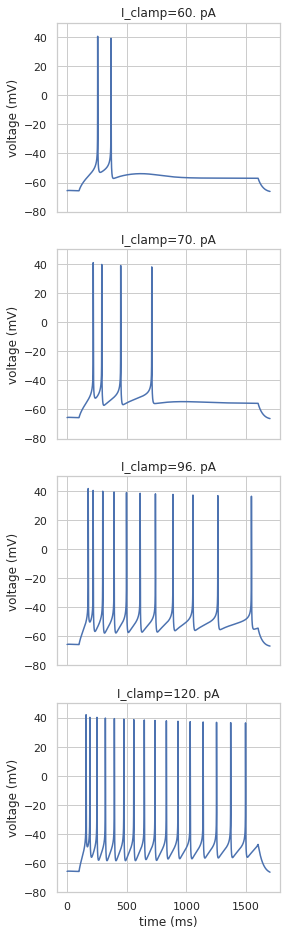

In [41]:
fig, axes = plt.subplots(4, 1, figsize=(4, 16), sharex=True, sharey=True)
for i in range(len(somatic_currents)):
    axes[i].plot(times, voltages[i])
    axes[i].set(ylabel='voltage (mV)', ylim=((-80, 50)), title='I_clamp=%s' %somatic_currents[i])
axes[-1].set(xlabel='time (ms)')
plt.show()

In [43]:
briannet.restore(name='init')

PC.main.g_hva = 0.272*msiemens/cm**2  # 0%DA=0.34, 100%DA=0.272
PC.main.g_ks = 0.07*msiemens/cm**2  # 0%DA=0.14, 100%DA=0.07

PC.basal.g_hva = 0.56*msiemens/cm**2  # 0%DA=0.7, 100%DA=0.56
PC.basal.g_ks = 0.12*msiemens/cm**2  # 0%DA=0.24, 100%DA=0.12

PC.prox.g_hva = 0.56*msiemens/cm**2  # 0%DA=0.7, 100%DA=0.56
PC.prox.g_ks = 0.12*msiemens/cm**2  # 0%DA=0.24, 100%DA=0.12

PC.prox.dist.g_hva = 0.17*msiemens/cm**2  # 0%DA=0.34, 100%DA=0.17
PC.prox.dist.g_ks = 0.12*msiemens/cm**2  # 0%DA=0.24, 100%DA=0.12

PC.k_nap_alpha_m = 17  # 0%DA=12, 100%DA=17 OR 14?
PC.k_nap_beta_m = 10  # 0%DA=15, 100%DA=10
PC.k_nap_alpha_h = 2.0e-5  # 0%DA=2.8e-5, 100%DA=2.0e-5
PC.k_nap_beta_h = 0.014286  # 0%DA=0.02, 100%DA=0.014286

somatic_currents = [96*pamp]
voltages = []
t_settle = 100*ms
t_clamp = 1500*ms

briannet.run(t_settle, report='text')
PC.main.I = somatic_currents[0]
briannet.run(t_clamp, report='text')
PC.I = 0*amp
briannet.run(t_settle, report='text')
times = np.array(v_mon.t/ms)
voltages.append(np.array(v_mon.v[0,:]/mV))

Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in 1s
Starting simulation at t=100. ms for a duration of 1.5 s
0.6088828125 (40%) simulated in 10s, estimated 15s remaining.
1.217625 (81%) simulated in 20s, estimated 5s remaining.
1.5 (100%) simulated in 23s
Starting simulation at t=1.6 s for a duration of 100. ms
0.1 (100%) simulated in 1s


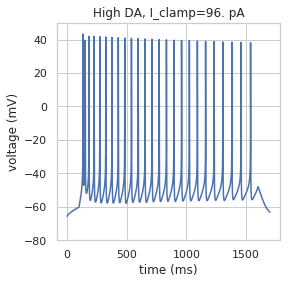

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)
for i in range(len(somatic_currents)):
    axes.plot(times, voltages[i])
    axes.set(ylabel='voltage (mV)', ylim=((-80, 50)), title='High DA, I_clamp=%s' %somatic_currents[i])
axes.set(xlabel='time (ms)')
plt.show()

In [ ]:
%%script false

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(v_mon.t/ms, I_leak_mon.I_leak[0,:]/(amp/meter**2), label='I_leak')
ax.plot(v_mon.t/ms, I_na_mon.I_na[0,:]/(amp/meter**2), label='I_na')
ax.plot(v_mon.t/ms, I_nap_mon.I_nap[0,:]/(amp/meter**2), label='I_nap')
ax.plot(v_mon.t/ms, I_hva_mon.I_hva[0,:]/(amp/meter**2), label='I_hva')
ax.plot(v_mon.t/ms, I_dr_mon.I_dr[0,:]/(amp/meter**2), label='I_dr')
ax.plot(v_mon.t/ms, I_ks_mon.I_ks[0,:]/(amp/meter**2), label='I_ks')
ax.plot(v_mon.t/ms, I_c_mon.I_c[0,:]/(amp/meter**2), label='I_c')
# ax.plot(v_mon.t/ms, (I_na_mon.I_na[0,:]+I_nap_mon.I_nap[0,:])/(amp/meter**2), label='I_na')
# ax.plot(v_mon.t/ms, I_hva_mon.I_hva[0,:]/(amp/meter**2), label='I_ca')
# ax.plot(v_mon.t/ms, (I_dr_mon.I_dr[0,:]+I_ks_mon.I_ks[0,:]+I_c_mon.I_c[0,:])/(amp/meter**2), label='I_k')
ax.set(ylabel='Current (amp/meter**2)', title='Ionic currents')
ax.legend(loc='lower left')
plt.show()

In [ ]:
%%script false

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(v_mon.t/ms, m_na_mon.m_na[0,:], label='m_na')
ax.plot(v_mon.t/ms, h_na_mon.h_na[0,:], label='h_na')
ax.plot(v_mon.t/ms, m_nap_mon.m_nap[0,:], label='m_nap')
ax.plot(v_mon.t/ms, u_hva_mon.u_hva[0,:], label='u_hva')
ax.plot(v_mon.t/ms, v_hva_mon.v_hva[0,:], label='v_hva')
ax.plot(v_mon.t/ms, n_dr_mon.n_dr[0,:], label='n_dr')
ax.plot(v_mon.t/ms, a_ks_mon.a_ks[0,:], label='a_ks')
ax.plot(v_mon.t/ms, b_ks_mon.b_ks[0,:], label='b_ks')
ax.plot(v_mon.t/ms, c_c_mon.c_c[0,:], label='c_c')
ax.legend()
ax.set(title='gating variables')
plt.show()

In [19]:
%%script false

## currents from NEURON, flipped sign
I_leak = 0.000144 to 0.00017

I_na = -1.7e-5 to -1.6e-5
I_nap  = -0.0006 to -0.00057
I_hva = -4.4e-5 to -4.2e-5
I_dr = 0.000175 to 0.000155
I_ks = 1.5e-5 to 1.3e-5
I_c = 5.5e-9 to 5e-9

I_cap = 5e-5 to -5e-6ish  # this might be I_total, since it goes to zero after ~300 ms

I_ca = -4.75e-5 to -4.2e-5
I_k = 0.0002 to 0.000165
I_na = -0.000625 to -0.00059

print('leak', I_leak_mon.I_leak[0,-1]/10/(amp/meter**2))
print('na', I_na_mon.I_na[0,-1]/10/(amp/meter**2))
print('nap', I_nap_mon.I_nap[0,-1]/10/(amp/meter**2))
print('hva', I_hva_mon.I_hva[0,-1]/10/(amp/meter**2))
print('dr', I_dr_mon.I_dr[0,-1]/10/(amp/meter**2))
print('ks', I_ks_mon.I_ks[0,-1]/10/(amp/meter**2))
print('c', I_c_mon.I_c[0,-1]/10/(amp/meter**2))

print(m_na_mon_inf.m_na_inf[0,-1])
print(h_na_mon_inf.h_na_inf[0,-1])
print(m_nap_mon_inf.m_nap_inf[0,-1])
print(h_nap_mon_inf.h_nap_inf[0,-1])
print(u_hva_mon_inf.u_hva_inf[0,-1])
print(v_hva_mon_inf.v_hva_inf[0,-1])
print(n_dr_mon_inf.n_dr_inf[0,-1])
print(a_ks_mon_inf.a_ks_inf[0,-1])
print(b_ks_mon_inf.b_ks_inf[0,-1])
print(c_c_mon_inf.c_c_inf[0,-1])

print('delta E_k = %s' %(np.max(E_k_mon.E_k[0,:])-np.min(E_k_mon.E_k[0,:])))
print('delta E_ca = %s' %(np.max(E_ca_mon.E_ca[0,:])-np.min(E_ca_mon.E_ca[0,:])))

### GABA Interneuron Model

In [ ]:
param_IN = {
    'E_na': 55*mV,
    'E_leak': -68*mV,
    'k_rest': 3.82*mmole/liter,
    'k_out': 3.82*mmole/liter, #remove
    'k_in': 140*mmole/liter,
    'g_na': 100.0*msiemens/cm**2,  # soma
    'g_dr': 40.0*msiemens/cm**2,  # soma
#     'g_leak': 0.3*msiemens/cm**2,  # todo
    'g_leak': 1.0/(100*kohm*cm**2),  # todo
    'C_m': 1.0*ufarad/cm**2,
    'R_i': 150*ohm*cm,
    'phi_k': 386*10**(-9),  # soma
    'F': 96485.33289 * coulomb/mole,  # Faraday's constant
    'V_shell_k': 4*np.pi/3 * ((7.5*um+70*nmeter)**3 - (7.5*um)**3),  # soma  # shell of thickness 70 nm
    'tau_k': 7.0*ms,
}

In [ ]:
eqns_IN = ''' 

# TOTAL CURRENT
Im = I_leak + I_na + I_dr: amp/meter**2 


# INJECTED
I : amp (point current)


# LEAK
I_leak = g_leak * (E_leak - v) : amp/meter**2


# SODIUM
I_na = g_na * (E_na - v) * m_na**3 * h_na : amp/meter**2
dm_na/dt = (m_na_inf - m_na) / tau_m_na : 1
m_na_inf = alpha_m_na / (alpha_m_na + beta_m_na) : 1
tau_m_na = 1.0*ms / (alpha_m_na + beta_m_na) : second
alpha_m_na = 4.2*exp((v + 34.5*mV)/(11.57*mV)) : 1
beta_m_na = 4.2*exp(-(v + 34.5*mV)/(27*mV)) : 1
dh_na/dt = (h_na_inf - h_na) / tau_h_na : 1
h_na_inf = alpha_h_na / (alpha_h_na + beta_h_na) : 1
tau_h_na = 1.0*ms / (alpha_h_na + beta_h_na) : second
alpha_h_na = 0.09*exp(-(v + 45*mV)/(33*mV)) : 1
beta_h_na = 0.09*exp((v + 45*mV)/(12.2*mV)) : 1


# POTASSIUM
E_k = 25.0*mV * log(k_out / k_in) : volt
# dk_out/dt = -phi_k * (I_dr*(meter**2) / (F*V_shell_k)) + (k_rest - k_in)/tau_k : mole/meter**3

I_dr = g_dr * (E_k - v) * n_dr**4 : amp/meter**2
dn_dr/dt = (n_dr_inf - n_dr) / tau_n_dr : 1
n_dr_inf = alpha_n_dr / (alpha_n_dr + beta_n_dr) : 1
tau_n_dr = 1.0*ms / (alpha_n_dr + beta_n_dr) : second
alpha_n_dr = 0.3*(exp((v + 35*mV)/(10.67*mV))) : 1
beta_n_dr = 0.3*(exp(-(v + 35*mV)/(42.68*mV))) : 1

'''

In [ ]:
soma_IN = Soma(diameter=15.0*um)
# soma_IN = Cylinder(l=10*cm, diameter=2*238*um, n=1000, type='axon')

IN = SpatialNeuron(morphology=soma_IN, model=eqns_IN, method='exponential_euler',
    refractory="m_na > 0.4", threshold="m_na > 0.5",  # todo
    namespace=param_IN, Cm=param_IN['C_m'], Ri=param_IN['R_i'])

v_mon = StateMonitor(IN, 'v', record=True)
m_na_mon = StateMonitor(IN, 'm_na', record=True)
h_na_mon = StateMonitor(IN, 'h_na', record=True)
n_dr_mon = StateMonitor(IN, 'n_dr', record=True)
s_mon = SpikeMonitor(IN)

defaultclock.dt = 0.01*ms
IN.v = -66.0*mV
IN.m_na = 0
IN.h_na = 1
IN.n_dr = 0.5
# IN.k_out = 3.82*nmole/liter

briannet_IN = Network(IN, v_mon, m_na_mon, h_na_mon, n_dr_mon)

IN.I = 0*uamp  # current injection
briannet_IN.run(10*ms, report='text')
IN.I = 1*namp  # current injection
briannet_IN.run(3*ms, report='text')
IN.I = 0*uamp  # current injection
briannet_IN.run(10*ms, report='text')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(m_na_mon.m_na[0,:], label='m')
ax1.plot(h_na_mon.h_na[0,:], label='h')
ax1.plot(n_dr_mon.n_dr[0,:], label='n')
ax1.legend()
ax2.plot(v_mon.t/ms, v_mon.v[0,:]/mV)
ax2.set(xlabel='time (ms)', ylabel='voltage (mV)', ylim=((-85, 20)))
plt.show()